In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal
from tqdm.notebook import tqdm
import rasterio as rio
from shapely.geometry import Point, LineString, Polygon, MultiPoint
import fiona
from shapely.ops import nearest_points

In [2]:
!pwd

/Users/home/whitefar/DATA/Jupyter/REMA


In [3]:
# !ls /Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/


In [4]:
x_interpd = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_line2line_interpbydist_points_x.npy')
y_interpd = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_line2line_interpbydist_points_y.npy')
# it_interpd = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydist_ice_thickn.npy')
# ib_interpd = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_line2line_interpbydist_icebase.npy')

In [5]:
path = "/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/from_huw/kis2_remaDebiasMeanMaskedNAN.tif"
with rio.open(path) as image:
    im = image.read(1)
#     im[im==-9999] = np.nan
    extent_REMAdiff = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
    left = image.bounds[0]
    bottom = image.bounds[1]
    right = image.bounds[2]    
    top = image.bounds[3]
    

In [10]:
x = np.linspace(left,right, im.shape[1])
y = np.linspace(top,bottom, im.shape[0])
xv, yv = np.meshgrid(x ,y ) 

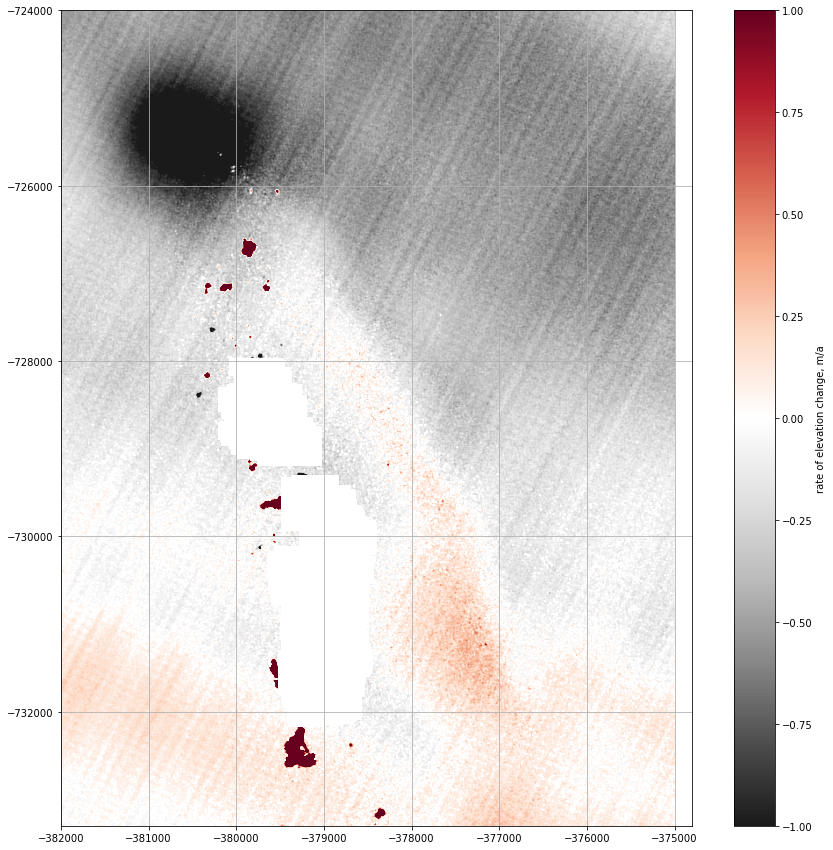

In [7]:
plt.figure(figsize=(15,15))
GyRd = plt.cm.get_cmap('RdGy').reversed()
plt.imshow(im,extent=extent_REMAdiff, vmin=-1,vmax=1,cmap=GyRd)
cb = plt.colorbar()
cb.set_label('rate of elevation change, m/a')
plt.xlim([-382000, -374800])
plt.ylim([-733300,-724000])
plt.grid()
plt.show()

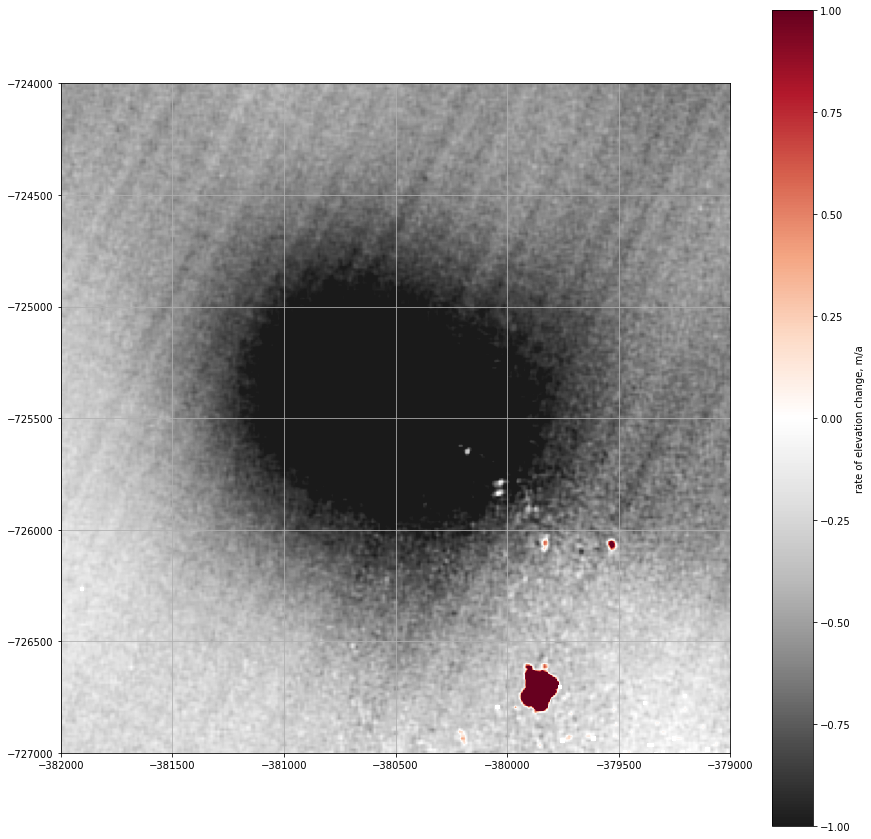

In [8]:
plt.figure(figsize=(15,15))
GyRd = plt.cm.get_cmap('RdGy').reversed()
plt.imshow(im,extent=extent_REMAdiff, vmin=-1,vmax=1,cmap=GyRd)
cb = plt.colorbar()
cb.set_label('rate of elevation change, m/a')
plt.xlim([-382000, -379000])
plt.ylim([-727000,-724000])
plt.grid()
plt.show()

In [26]:
# 2. make 3D array of [elevation change, xv, yv]
elevs = np.array([xv,yv,im])
elevs_red = elevs[:,(im < -0.5) & (xv > -382000) & (xv<-379000) &
              ( yv > -727000)  & ( yv < -724000)]
elevs = elevs[:, (xv > -382000) & (xv<-379000) &
              ( yv > -727000)  & ( yv < -724000)] 



/Users/home/whitefar/miniconda3/envs/remote_sensing/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


In [12]:
df = pd.DataFrame({'x': elevs[0,:],
                        'y': elevs[1,:],
                        'dzdt':elevs[2,:]})

In [28]:
bullseye = gpd.read_file('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/shapefiles/kis2_remaBullseye.shp').geometry[0]

In [49]:
bullseye.area

3382400.178781191

In [15]:
# del elevs, xv, yv, im

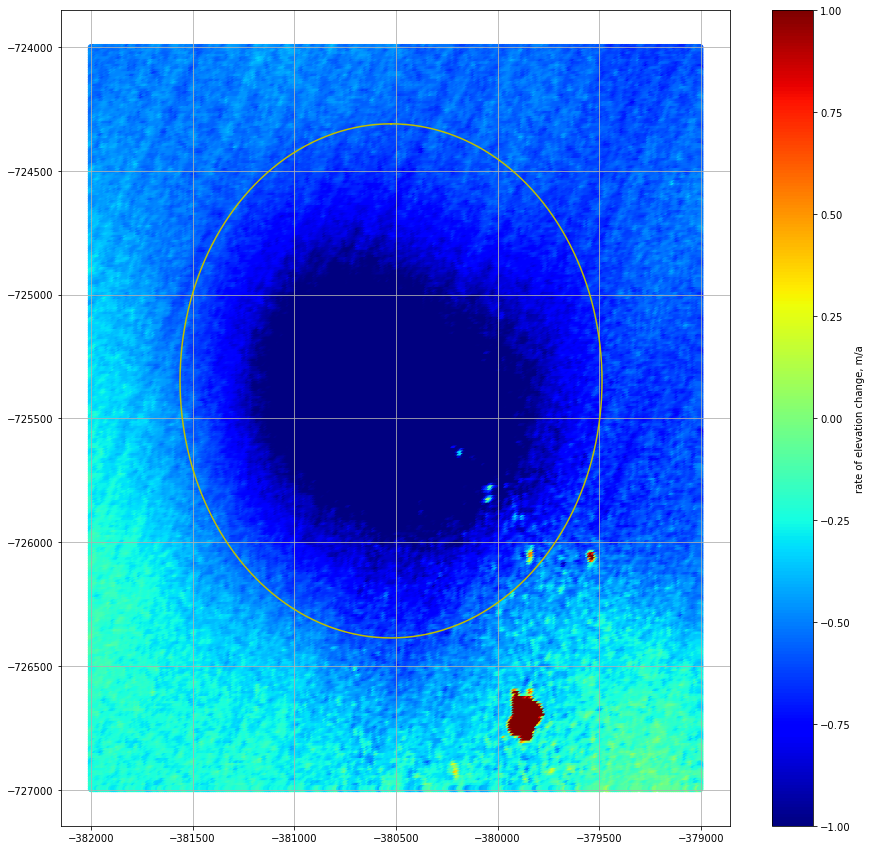

In [33]:
plt.figure(figsize=(15,15))
GyRd = plt.cm.get_cmap('RdGy').reversed()
plt.scatter(elevs[0,:],elevs[1,:],c=elevs[2,:],vmin=-1,vmax=1,cmap='jet')
cb = plt.colorbar()
cb.set_label('rate of elevation change, m/a')
plt.plot(bullseye.exterior.xy[0],bullseye.exterior.xy[1],'y')
# plt.xlim([-382000, -374800])
# plt.ylim([-733300,-724000])
plt.grid()
plt.show()

In [20]:
print('median melt rate = ',np.nanmedian(elevs[2,:]))

median melt rate =  -0.5600000023841858


In [22]:
print('mean melt rate = ',np.nanmean(elevs[2,:]))

mean melt rate =  -0.5881249333744333


In [34]:
# # 1. make a polygon of downwasting
# bullseye_mp = MultiPoint( [(x,y) for x,y in zip(elevs_red[0,:],elevs_red[1,:])])
# bullseye_mp

In [35]:
# bullseye = bullseye_mp.convex_hull


In [32]:
del elevs_red, bullseye_mp, elevs_red_area

In [36]:
geometry = [Point(xy) for xy in zip(df.x,df.y)]
gdf= gpd.GeoDataFrame(df,geometry=geometry,crs="EPSG:3031")

In [37]:
gdf['in_bullseye'] = gdf.geometry.intersects(bullseye)

In [38]:
#ThIS IS THE GOOD ONE TO USE - VOLUME DOWNWASTED
volume_loss = gdf[gdf['in_bullseye']==True].dzdt.sum()*pixel

In [39]:
volume_loss

-3001505.8808011184

In [50]:
bullseye.area

3382400.178781191

In [41]:
# bullseye.area*np.mean(elevs_red[2,:])

In [42]:
# 2. make a polygon of channel
chan_right =  [(x,y) for x,y in zip(x_interpd[0,::-1],y_interpd[0,::-1])]
chan_left =  [(x,y) for x,y in zip(x_interpd[-1,:],y_interpd[-1,:])]
chan_beg = [(x,y) for x,y in zip(x_interpd[:,0],y_interpd[:,0])]
chan_end = [(x,y) for x,y in zip(x_interpd[::-1,-1],y_interpd[::-1,-1])]

In [43]:
chan = Polygon(chan_left+chan_end+chan_right+chan_beg)

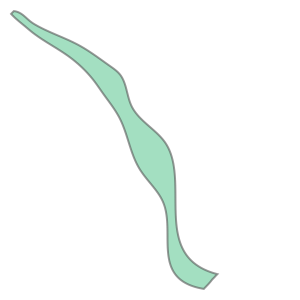

In [44]:
chan

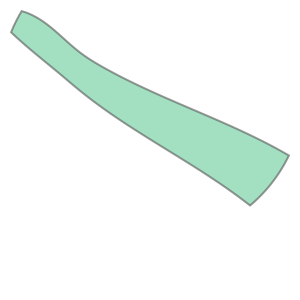

In [45]:
# 3. get intersection
melt_under = chan.intersection(bullseye)
melt_under

In [46]:
# 4. see downwasting rate in intersection

In [47]:
print("melt rate in 1D m / a underneath  = ",volume_loss / melt_under.area)
print("without hydrostatic adjustment")

melt rate in 1D m / a underneath  =  -5.064327594796884


In [53]:
print("melt rate in 1D m / a underneath  = ",volume_loss / melt_under.area *9)
print("with hydrostatic adjustment")

melt rate in 1D m / a underneath  =  -45.57894835317196
with hydrostatic adjustment


In [48]:
X0a = Point(x_interpd[0,0],y_interpd[0,0])
X0b = Point(x_interpd[-1,0],y_interpd[-1,0])

print('width of channel is ',X0a.distance(X0b),'m')

width of channel is  109.2562584016489 m


In [62]:
5.06/(1-1030/895)

-33.54592592592592